# Monitoring Water Quality<img align="right" src="../Supplementary_data/dea_logo.jpg">

* **[Sign up to the DEA Sandbox](https://app.sandbox.dea.ga.gov.au/)** to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment

* **Products used:** 
[ga_ls8c_ard_3](https://explorer.dea.ga.gov.au/products/ga_ls8c_ard_3), 
[ga_ls_wo_3](https://explorer.dea.ga.gov.au/products/ga_ls_wo_3)

## Background
The UN [SDG 6.3.2](https://www.sdg6monitoring.org/indicator-632/) indicator is the "proportion of bodies of water with good ambient water quality", which is part of the Sustainable Development Goal 6 - "Ensure access to water and sanitation for all". There are many ways to measure water quality using remote sensing based algorithms; this notebook compares several of them. They usually estimate the amount of suspended matter in water.

## Description
This notebook shows results for three empirical algorithms and one spectral index addressing total suspended matter (TSM) in water.
There are a number of caveats to be aware of when applying these algorithms:

* These algorithms were developed for specific regions of the world and are not necessarily universally valid.
* Landsat-8 data is a surface reflectance product, and since water has a very low radiance, the accuracy of the results can be severaly impacted by small differences in atmospheric conditions, or differences in atmospheric correction algorithms.
* The colorbars for these results have been removed to avoid showing specific quantities for the TSM results. It is best to use these results to assess qualitative changes in water quality (e.g. low, medium, high). With improvements in analysis-ready data (e.g. water leaving radiance), and with in-situ sampling of water bodies for empirical modelling, it will be possible to increase the accuracy of these water quality results and even consider the numerical output. 


The showcased water quality algorithms are:

1. Lymburner Total Suspended Matter (TSM)
2. Suspended Particulate Model (SPM)
3. Normalized Difference Suspended Sediment Index (NDSSI)
4. Quang Total Suspended Solids (TSS)

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [26]:
%matplotlib inline

# Force GeoPandas to use Shapely instead of PyGEOS
# In a future release, GeoPandas will switch to using Shapely by default.
import os

os.environ["USE_PYGEOS"] = "0"

import datacube
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from dea_tools.plotting import display_map, rgb
from dea_tools.datahandling import load_ard, mostcommon_crs, wofs_fuser

from IPython.display import display, Markdown
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [27]:
dc = datacube.Datacube(app="Monitoring_water_quality")

### Analysis parameters

The following cell sets important parameters for the analysis. The parameters are:

* `lat`: The central latitude to analyse (e.g. `10.338`).
* `lon`: The central longitude to analyse (e.g. `-1.055`).
* `lat_buffer`: The number of degrees to load around the central latitude.
* `lon_buffer`: The number of degrees to load around the central longitude.
* `time_range`: The time range to analyze - in YYYY-MM-DD format (e.g. `('2016-01-01', '2016-12-31')`).

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers water quality in Cotter Dam.

**To run the notebook for a different area**, make sure Landsat 8 data is available for the chosen area using the [DEA Explorer](https://explorer.dea.ga.gov.au/).
Use the drop-down menu to check Landsat 8 (`ga_ls8c_ard_3`).

#### Suggested areas
Here are some suggestions for areas to look at. To view one of these areas, copy and paste the parameter values into the cell below, then run the notebook.

**Cotter Dam**
```
lon = 148.92
lat = -35.32

lat_buffer = 0.03
lon_buffer = 0.03
```

**Lake Burley Griffith**
```
lon = 149.11
lat = -35.30

lat_buffer = 0.03
lon_buffer = 0.05

```

**Corin Dam**
```
lon = 148.83
lat = -35.55

lat_buffer = 0.05
lon_buffer = 0.05

```

**Googong Dam**
```
lon = 149.27
lat = -35.45

lat_buffer = 0.05
lon_buffer = 0.05

```

### Select location

In [28]:
# Define the area of interest
lon = 148.92
lat = -35.32

lat_buffer = 0.03
lon_buffer = 0.03

# Time period
time_range = ["2023-09-05", "2023-09-07"]

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [29]:
# The code below renders a map that can be used to view the region.
display_map(lon_range, lat_range)

## Load the data
We can use the load_ard function to load data from multiple satellites (i.e. Landsat 7 and Landsat 8), and return a single `xarray.Dataset` containing only observations with a minimum percentage of good quality pixels.

In the example below, we request that the function returns only observations which are 90% free of clouds and other poor quality pixels by specifying `min_gooddata=0.90`.

In [30]:
# Create the 'query' dictionary object, which contains the longitudes,
# latitudes and time provided above
query = {
    "x": lon_range,
    "y": lat_range,
    "time": time_range,
    "resolution": (-30, 30),
}

# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product="ga_ls8c_ard_3", query=query)

# Load available data
ds = load_ard(
    dc=dc,
    products=["ga_ls8c_ard_3"],
    measurements=["nbart_red", "nbart_green", "nbart_blue", "nbart_nir"],
    group_by="solar_day",
    dask_chunks={"time": 1, "x": 2000, "y": 2000},
    min_gooddata=0.90,
    output_crs=output_crs,
    **query
)

Finding datasets
    ga_ls8c_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 1 out of 1 time steps with at least 90.0% good quality pixels
Applying fmask pixel quality/cloud mask
Returning 1 time steps as a dask array


**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` attribute revels the number of time steps in the data set, as well as the number of pixels in the `x` (longitude) and `y` (latitude) dimensions.

In [31]:
print(ds)

<xarray.Dataset>
Dimensions:      (time: 1, y: 226, x: 187)
Coordinates:
  * time         (time) datetime64[ns] 2023-09-05T23:50:15.646609
  * y            (y) float64 -3.907e+06 -3.907e+06 ... -3.914e+06 -3.914e+06
  * x            (x) float64 6.717e+05 6.718e+05 ... 6.773e+05 6.773e+05
    spatial_ref  int32 32655
Data variables:
    nbart_red    (time, y, x) float32 dask.array<chunksize=(1, 226, 187), meta=np.ndarray>
    nbart_green  (time, y, x) float32 dask.array<chunksize=(1, 226, 187), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 dask.array<chunksize=(1, 226, 187), meta=np.ndarray>
    nbart_nir    (time, y, x) float32 dask.array<chunksize=(1, 226, 187), meta=np.ndarray>
Attributes:
    crs:           epsg:32655
    grid_mapping:  spatial_ref


### Load WOfS

To make sure the algorithms for measuring water quality are only applied to areas with water, it is useful to extract the water extent from the [Water Observations (WO) product](https://explorer.dea.ga.gov.au/products/ga_ls_wo_3).
The water extent can then be used to mask the geomedian composite so that the water quality indices are only shown for pixels that are water.
Pixels that are water are selected using the condition that `water == 128`. 
To learn more about working with WOfS bit flags, see the [DEA Water Observations notebook](../DEA_products/DEA_Water_Observations.ipynb)

In [32]:
# Load water observations
water = dc.load(
    product="ga_ls_wo_3",
    group_by="solar_day",
    like=ds.geobox,
    dask_chunks={"time": 1, "x": 2000, "y": 2000},
    time=query["time"],
).water

# extract from mask the areas classified as water
water_extent = (water == 128).squeeze()

print(water_extent)

<xarray.DataArray 'water' (y: 226, x: 187)>
dask.array<getitem, shape=(226, 187), dtype=bool, chunksize=(226, 187), chunktype=numpy.ndarray>
Coordinates:
    time         datetime64[ns] 2023-09-05T23:50:15.646609
  * y            (y) float64 -3.907e+06 -3.907e+06 ... -3.914e+06 -3.914e+06
  * x            (x) float64 6.717e+05 6.718e+05 ... 6.773e+05 6.773e+05
    spatial_ref  int32 32655


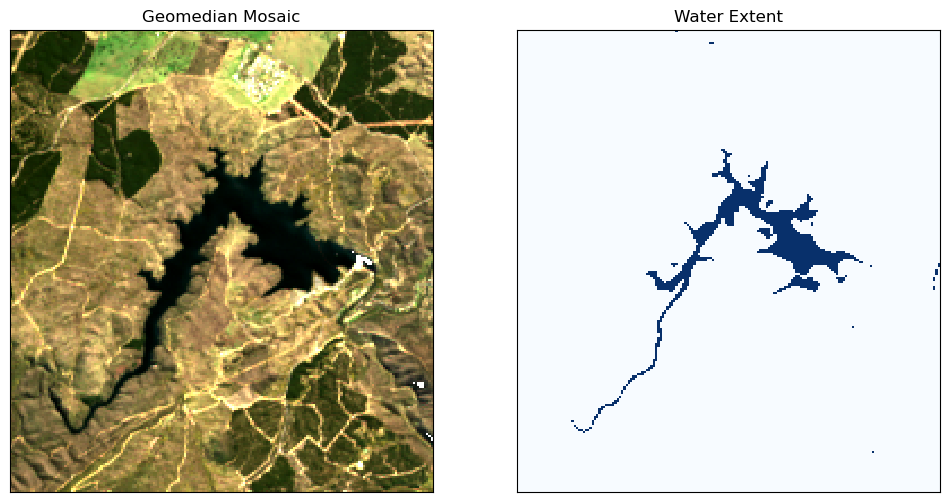

In [33]:
# Plot the geomedian composite and water extent
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# plot the true colour image
rgb(ds, ax=ax[0])

# plot the water extent from WO
water_extent.plot.imshow(ax=ax[1], cmap="Blues", add_colorbar=False)

# Titles
ax[0].set_title("Geomedian Mosaic"), ax[0].xaxis.set_visible(False), ax[
    0
].yaxis.set_visible(False)
ax[1].set_title("Water Extent"), ax[1].xaxis.set_visible(False), ax[
    1
].yaxis.set_visible(False);

## Total Suspended Sediment Algorithms

First we will calculate the water quality using each of the algorithms, then we wil compare the approaches.

### (1) Lymburner Total Suspended Matter (TSM)
Paper: [Lymburner et al. 2016](https://www.sciencedirect.com/science/article/abs/pii/S0034425716301560)

Units of mg/L concentration

TSM for Landsat 7:
$$
LYM7 = 3983 \cdot (\frac{(\text{Green} + \text{Red}) * 0.0001}{2})^{1.6246}
$$

TSM for Landsat 8:
$$
LYM8 = 3957 \cdot (\frac{(\text{Green} + \text{Red}) * 0.0001}{2})^{1.6436}
$$

Here, we're using Landsat 8, so we'll use the LYM8 function.

In [34]:
# Function to calculate Lymburner TSM value for Landsat 7
def LYM7(dataset):
    return 3983 * ((dataset.nbart_green + dataset.nbart_red) * 0.0001 / 2) ** 1.6246

In [35]:
# Function to calculate Lymburner TSM value for Landsat 8
def LYM8(dataset):
    return 3957 * ((dataset.nbart_green + dataset.nbart_red) * 0.0001 / 2) ** 1.6436

In [36]:
# Calculate the Lymburner TSM value for Landsat 8, using water extent to mask
lym8 = LYM8(ds).where(water_extent)

In [37]:
# Determine the 2% and 98% quantiles and set as min and max respectively
lym8_min = lym8.quantile(0.02).values
lym8_max = lym8.quantile(0.98).values

### (2) Suspended Particulate Model (SPM)
Paper: [Zhongfeng Qiu et.al. 2013](https://www.researchgate.net/publication/260152686_A_simple_optical_model_to_estimate_suspended_particulate_matter_in_Yellow_River_Estuary)

Units of g/m^3 concentration

SPM for Landsat 8:
$$
X = 2.26*(\frac{\text{Red}}{\text{Green}})^3 - 
           5.42*(\frac{\text{Red}}{\text{Green}})^2 +
           5.58*(\frac{\text{Red}}{\text{Green}}) - 0.72
$$

$$
SPM = 10^{X} - 1.43
$$

In [38]:
# Function to calculate Suspended Particulate Model value
def SPM_QIU(dataset):
    return (
        10
        ** (
            2.26 * (dataset.nbart_red / dataset.nbart_green) ** 3
            - 5.42 * (dataset.nbart_red / dataset.nbart_green) ** 2
            + 5.58 * (dataset.nbart_red / dataset.nbart_green)
            - 0.72
        )
        - 1.43
    )

In [39]:
# Calculate the SPM value for Landsat 8, using water extent to mask
spm_qiu = SPM_QIU(ds).where(water_extent)

In [40]:
# Determine the 2% and 98% quantiles and set as min and max respectively
spm_qiu_min = spm_qiu.quantile(0.02).values
spm_qiu_max = spm_qiu.quantile(0.98).values

### (3) Normalized Difference Suspended Sediment Index (NDSSI)
Paper: [Hossain et al. 2010](https://www.researchgate.net/publication/251236287_Development_of_Remote_Sensing_Based_Index_for_EstimatingMapping_Suspended_Sediment_Concentration_in_River_and_Lake_Environments)

NDSSI for Landsat 7 and 8:
$$
NDSSI = \frac{\text{Blue}-\text{NIR}}{\text{Blue}+\text{NIR}}
$$

The NDSSI value ranges from -1 to +1. Values closer to +1 indicate higher concentration of sediment.

In [41]:
# Function to calculate SNDSSI value
def NDSSI(dataset):
    return (dataset.nbart_blue - dataset.nbart_nir) / (
        dataset.nbart_blue + dataset.nbart_nir
    )

In [42]:
# Calculate the NDSSI value for Landsat 8, using water extent to mask
ndssi = NDSSI(ds).where(water_extent)

In [43]:
# Determine the 2% and 98% quantiles and set as min and max respectively
ndssi_min = ndssi.quantile(0.02).compute().values
ndssi_max = ndssi.quantile(0.98).compute().values

### (4) Quang Total Suspended Solids (TSS)
Paper: [Quang et al. 2017](https://www.mdpi.com/2073-4441/9/8/570)

Units of mg/L concentration

$$
Quang8 = 380.32 * \text{Red}*0.0001 - 1.7826
$$

In [44]:
# Function to calculate quang8 value
def QUANG8(dataset):
    return 380.32 * (dataset.nbart_red) * 0.0001 - 1.7826

In [45]:
# Calculate the quang8 value for Landsat 8, using water extent to mask
quang8 = QUANG8(ds).where(water_extent)

In [46]:
# Determine the 2% and 98% quantiles and set as min and max respectively
quang8_min = quang8.quantile(0.02).compute().values
quang8_max = quang8.quantile(0.98).compute().values

## Compare the algorithms' outputs

> NOTE:  Total Suspended Matter (Black=Low, Purple=Medium-Low, Orange=Medium-High, Yellow=High)

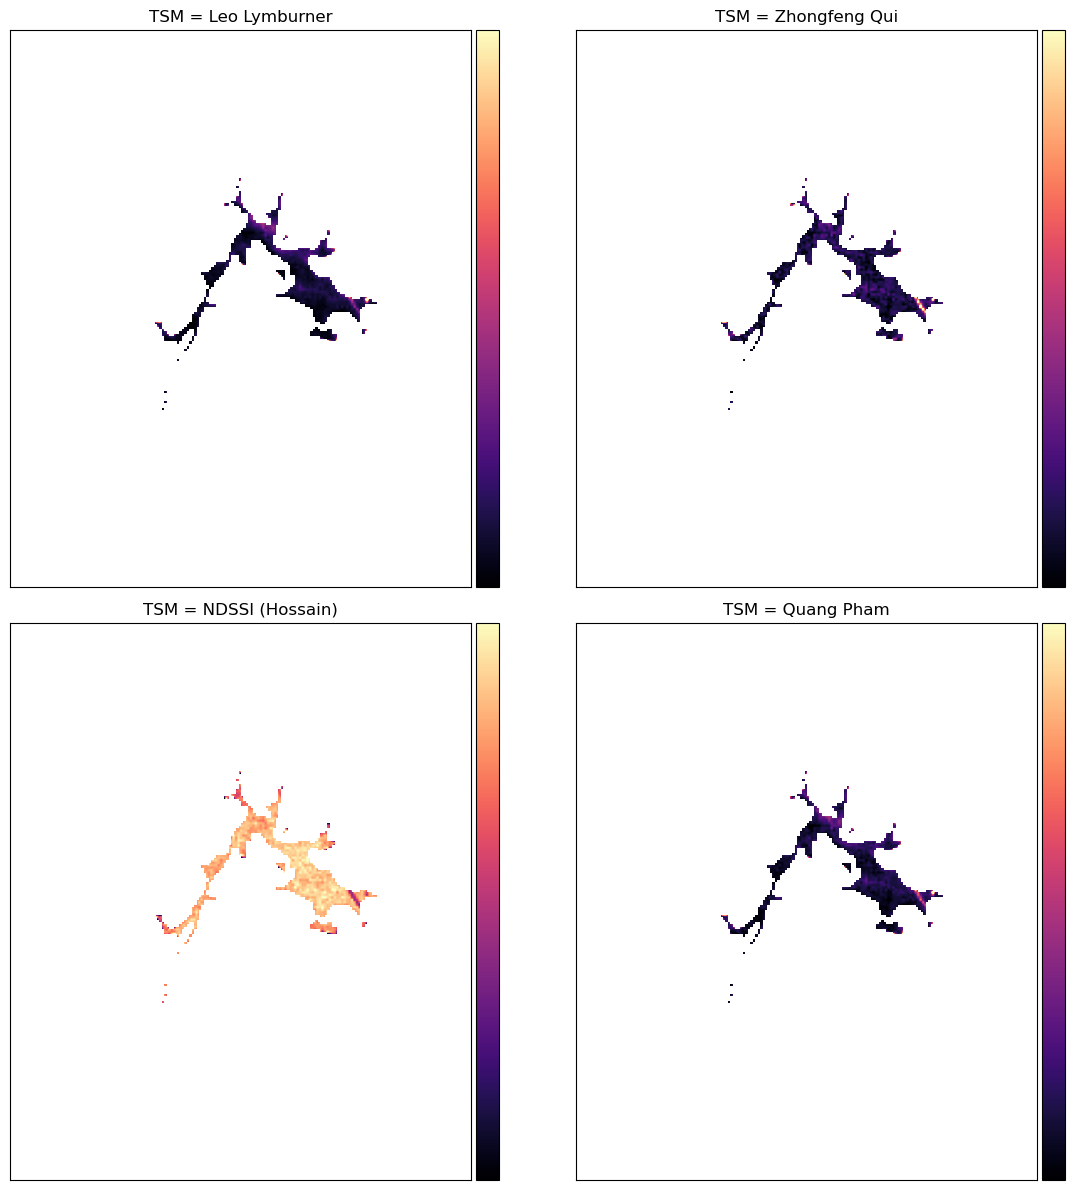

In [47]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
cmap = "magma"

ax1 = ax[0,0]
im1 = ax1.imshow(lym8.to_numpy()[0, :, :], vmin=lym8_min, vmax=lym8_max, cmap = cmap)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, orientation='vertical')
cbar.set_ticks([])


ax2 = ax[0,1]
im2 = ax2.imshow(spm_qiu.to_numpy()[0, :, :], vmin=spm_qiu_min, vmax=spm_qiu_max, cmap = cmap)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im2, cax=cax, orientation='vertical')
cbar.set_ticks([])


ax3 = ax[1,0]
im3 = ax3.imshow(ndssi.to_numpy()[0, :, :], vmin=ndssi_min, vmax=ndssi_max, cmap = cmap)
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im3, cax=cax, orientation='vertical')
cbar.set_ticks([])


ax4 = ax[1,1]
im4 = ax4.imshow(quang8.to_numpy()[0, :, :], vmin=quang8_min, vmax=quang8_max, cmap = cmap)
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im4, cax=cax, orientation='vertical')
cbar.set_ticks([])

text = "> NOTE:  Total Suspended Matter (Black=Low, Purple=Medium-Low, Orange=Medium-High, Yellow=High)"

# Titles
ax[0, 0].set_title("TSM = Leo Lymburner"), ax[0, 0].xaxis.set_visible(False), ax[0, 0].yaxis.set_visible(False)
ax[0, 1].set_title("TSM = Zhongfeng Qui"), ax[0, 1].xaxis.set_visible(False), ax[0, 1].yaxis.set_visible(False)
ax[1, 0].set_title("TSM = NDSSI (Hossain)"), ax[1, 0].xaxis.set_visible(False), ax[1, 0].yaxis.set_visible(False)
ax[1, 1].set_title("TSM = Quang Pham"), ax[1, 1].xaxis.set_visible(False), ax[1, 1].yaxis.set_visible(False)
fig.tight_layout()
Markdown(text)

If the default settings were used, we should see that all the indices reflect the appearance of the lake (where murky, the index is high) except NDSSI, though it does appear to be related to the others - mostly low where the others are high and vice versa.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** December 2023

**Compatible datacube version:** 

In [50]:
print(datacube.__version__)

1.8.13


In [51]:
from datetime import datetime

datetime.today().strftime("%Y-%m-%d")

'2023-10-03'

## Tags
<!-- Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex/) -->